# 네이버 영화리뷰 감성 분석

### 데이터 로드

In [1]:
# 데이터 다운로드
from tensorflow.keras.utils import get_file

ratings_train_path = get_file("ratings_train.txt", "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt")
ratings_test_path = get_file("ratings_test.txt", "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt")

ratings_train_path, ratings_test_path

('C:\\Users\\lemon\\.keras\\datasets\\ratings_train.txt',
 'C:\\Users\\lemon\\.keras\\datasets\\ratings_test.txt')

In [2]:
# 데이터프레임 생성
import pandas as pd

ratings_train_df = pd.read_csv(ratings_train_path, sep='\t')
ratings_test_df = pd.read_csv(ratings_test_path, sep='\t')

display(ratings_train_df, ratings_test_df)   

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


### 데이터 전처리

In [3]:
# 결측치 제거
ratings_train_df = ratings_train_df.dropna(how='any')
ratings_test_df = ratings_test_df.dropna(how='any')

ratings_train_df.shape, ratings_test_df.shape

((149995, 3), (49997, 3))

In [ ]:
from konlpy.tag import Okt
from nltk.stem import PorterStemmer
from tqdm import tqdm
import re

stop_words = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 한글 토큰화 전처리 (특수문자 처리, 어간 추출, 불용어 처리)
def preprocessing(df):
    okt = Okt()
    stemmer = PorterStemmer()
    preprocessed_texts = []
    vocab = {}

    for sentence in tqdm(df['document']):
        text = re.sub('[^ㄱ-ㅎ가-핳a-zA-Z0-9 ]', '', sentence)
        tokens = okt.morphs(text, stem=True)
        stemmed_tokens = [stemmer.stem(token) for token in tokens]
        tokens = [token for token in stemmed_tokens if token not in stop_words]
        
        # vocab 생성
        for token in tokens:
            if token not in vocab:
                vocab[token] = 1
            else:
                vocab[token] += 1
        
        preprocessed_texts.append(tokens)
    
    return preprocessed_texts, vocab

In [5]:
# 훈련데이터 전처리

preprocessed_train, train_vocab = preprocessing(ratings_train_df)
preprocessed_train

100%|██████████| 149995/149995 [07:35<00:00, 328.98it/s]


[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['포스터', '보고', '초딩', '영', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'],
 ['교도소', '이야기', '구먼', '솔직', '재미', '없다', '평점', '조정'],
 ['사이',
  '몬페',
  '그',
  '익살스럽다',
  '연기',
  '돋보이다',
  '영',
  '스파이더맨',
  '에서',
  '늙다',
  '보이다',
  '던',
  '커스틴',
  '던스트',
  '너무나도',
  '이쁘다',
  '보이다'],
 ['막',
  '걸음',
  '마',
  '떼다',
  '3',
  '세',
  '부터',
  '초등학교',
  '1',
  '학년',
  '생인',
  '8',
  '살다',
  '영',
  'ㅋㅋㅋ',
  '별',
  '반개',
  '아깝다',
  '움'],
 ['원작', '긴장감', '을', '제대로', '살리다'],
 ['별',
  '반개',
  '아깝다',
  '욕',
  '나오다',
  '이응경',
  '길용우',
  '연',
  '기생',
  '몇',
  '년',
  '인지',
  '정말',
  '발',
  '로',
  '그것',
  '보단',
  '낫다',
  '납치',
  '감금',
  '만',
  '반복',
  '반복',
  '드라마',
  '가족',
  '없다',
  '연기',
  '못',
  '사람',
  '만',
  '모',
  '엿',
  '네'],
 ['액션', '없다', '재미', '있다', '몇', '안되다', '영'],
 ['왜케',
  '평점',
  '낮다',
  '꽤',
  '볼',
  '만',
  '데',
  '리',
  '우드',
  '식',
  '려함',
  '에만',
  '너무',
  '길들이다',
  '있다'],
 ['인피니트', '짱', '이다', '진짜', '짱', '이다'],
 ['볼때',
  '

In [6]:
# 평가데이터 전처리

preprocessed_test, _ = preprocessing(ratings_test_df)
preprocessed_test

100%|██████████| 49997/49997 [02:13<00:00, 374.49it/s]


[['굳다', 'ㅋ'],
 ['gdntopclassintheclub'],
 ['뭐', '야', '평점', '나쁘다', '않다', '10', '점', '짜다', '리', '더', '더욱', '아니다'],
 ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는'],
 ['3',
  'd',
  '만',
  '아니다',
  '별',
  '다섯',
  '개',
  '주다',
  '왜',
  '3',
  'd',
  '로',
  '나오다',
  '제',
  '심기',
  '불편하다'],
 ['음악', '주가', '되다', '최고', '음악', '영'],
 ['진정하다', '쓰레기'],
 ['마치',
  '미국',
  '애니',
  '에서',
  '튀어나오다',
  '창의력',
  '없다',
  '로봇',
  '디자인',
  '부터가',
  '고개',
  '젖다'],
 ['갈수록',
  '개판',
  '되다',
  '중국',
  '영',
  '유치하다',
  '내용',
  '없다',
  '폼',
  '잡다',
  '끝나다',
  '말',
  '안되다',
  '무기',
  '유치하다',
  'cg',
  '남무',
  '아',
  '그리다',
  '동사서독',
  '같다',
  '영',
  '이건',
  '3',
  '류',
  '아',
  '류작',
  '이다'],
 ['이별', '아픔', '뒤', '찾아오다', '새롭다', '인연', '기쁨', 'but', '모든', '사람', '그렇다', '않다'],
 ['괜찮다', '오랜', '만', '포켓몬스터', '잼밌', '어', '요'],
 ['한국', '독립', '영', '한계', '그렇게', '아버지', '되다', '비교', '되다'],
 ['청춘',
  '아름답다',
  '그',
  '아름답다',
  '움',
  '이성',
  '을',
  '들다',
  '놓다',
  '찰나',
  '아름답다',
  '움',
  '을',
  '자다',
  '포착',
  '섬세하다',
  '아름답다

In [ ]:
# sequence 작업 (단어사전 생성, 텍스트-수열 변환)
# from torchtext.vocab import build_vocab_from_iterator

# def yield_tokens(data):
#     for tokens in data:
#         yield tokens

In [7]:
# 단어사전 생성
vocab_sorted = sorted(train_vocab.items(), key=lambda item: item[1], reverse=True)
word_to_idx = {word: i+1 for i, (word, cnt) in enumerate(vocab_sorted)}

word_to_idx['OOV'] = len(word_to_idx) + 1
word_to_idx

{'영': 1,
 '보다': 2,
 '을': 3,
 '없다': 4,
 '이다': 5,
 '좋다': 6,
 '다': 7,
 '있다': 8,
 '너무': 9,
 '정말': 10,
 '만': 11,
 '재밌다': 12,
 '되다': 13,
 '로': 14,
 '진짜': 15,
 '같다': 16,
 '점': 17,
 '적': 18,
 '아니다': 19,
 '않다': 20,
 '에서': 21,
 '만들다': 22,
 '나오다': 23,
 '것': 24,
 '평점': 25,
 '연기': 26,
 '인': 27,
 '최고': 28,
 '내': 29,
 '나': 30,
 '그': 31,
 '늘다': 32,
 '스토리': 33,
 '안': 34,
 '생각': 35,
 '못': 36,
 '게': 37,
 '왜': 38,
 '고': 39,
 '드라마': 40,
 '요': 41,
 '감동': 42,
 '사람': 43,
 '1': 44,
 '보고': 45,
 '이렇다': 46,
 '주다': 47,
 '아깝다': 48,
 '말': 49,
 '더': 50,
 'ㅋㅋ': 51,
 '배우': 52,
 '때': 53,
 '감독': 54,
 '들다': 55,
 '재미있다': 56,
 '아': 57,
 '거': 58,
 '그냥': 59,
 '자다': 60,
 '재미': 61,
 '중': 62,
 '내용': 63,
 '뭐': 64,
 '까지': 65,
 '네': 66,
 '재미없다': 67,
 '가다': 68,
 '수': 69,
 '쓰레기': 70,
 '서': 71,
 '하고': 72,
 '시간': 73,
 '지': 74,
 '모르다': 75,
 '그렇다': 76,
 '싶다': 77,
 '10': 78,
 '오다': 79,
 '작품': 80,
 '사랑': 81,
 '알다': 82,
 '전': 83,
 '하나': 84,
 '다시': 85,
 '볼': 86,
 '마지막': 87,
 '지루하다': 88,
 '저': 89,
 '액션': 90,
 '완전': 91,
 'ㅋ': 92,
 '이건': 93,
 '

In [8]:
# 수열처리(= 정수 인코딩)
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=15, oov_token='<OOV>')
tokenizer.fit_on_texts(preprocessed_train)
train_sequences = tokenizer.texts_to_sequences(preprocessed_train)
test_sequences = tokenizer.texts_to_sequences(preprocessed_test)

In [9]:
# padding 작업
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_padded = pad_sequences(train_sequences, padding='post', maxlen=50, truncating='post')

test_padded = pad_sequences(test_sequences, padding='post', maxlen=50, truncating='post')

### 모델 생성 및 학습

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import matplotlib.pyplot as plt

# target label 생성
train_target = ratings_train_df['label'].values
test_target = ratings_test_df['label'].values

# torch Tensor 변환
train_data = torch.tensor(train_padded, dtype=torch.long)   
train_label = torch.tensor(train_target, dtype=torch.float) 
test_data = torch.tensor(test_padded, dtype=torch.long)
test_label = torch.tensor(test_target, dtype=torch.float)

# 모델 정의
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)   
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)            
        _, (hidden, _) = self.lstm(embedded)     
        out = self.fc(hidden[-1])                
        return self.sigmoid(out).squeeze()

In [ ]:
# 모델 인스턴스 생성
def train_func(train_data, train_label, model):
    BATCH_SIZE = 65
    train_size = int(len(train_data) * 0.8)
    val_size = len(train_data) - train_size

    train_dataset, val_dataset = random_split(TensorDataset(train_data, train_label), [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    epochs = 50
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    # 조기종료 관련 변수 초기화
    early_stopping_patience = 7
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        # 학습 단계
        model.train()
        total_loss, correct, total = 0, 0, 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = (outputs > 0.5).float()
            correct += (pred == targets).sum().item()
            total += targets.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # 검증 단계
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_outputs = model(val_inputs)
                loss = criterion(val_outputs, val_targets)
                val_loss += loss.item()

                val_pred = (val_outputs > 0.5).float()
                val_correct += (val_pred == val_targets).sum().item()
                val_total += val_targets.size(0)

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # 조기 종료 출력
        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # 조기 종료
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stopping_patience:
                print("Early Stopping 할게~~~~~!")
                break

    # 시각화
    history_df = pd.DataFrame({
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs
    })
    history_df.plot()
    plt.show()


VOCAB_SIZE = len(word_to_idx) + 1  
EMBEDDING_DIM = 64
HIDDEN_DIM = 128
OUTPUT_DIM = 1

lstm_model = SentimentLSTM(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM
)

print(lstm_model)

SentimentLSTM(
  (embedding): Embedding(45818, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch 1/50 | Train Loss: 0.6562, Train Acc: 0.5900, Val Loss: 0.6475, Val Acc: 0.6055
Epoch 2/50 | Train Loss: 0.6450, Train Acc: 0.6058, Val Loss: 0.6454, Val Acc: 0.6072
Epoch 3/50 | Train Loss: 0.6434, Train Acc: 0.6056, Val Loss: 0.6441, Val Acc: 0.6061
Epoch 4/50 | Train Loss: 0.6419, Train Acc: 0.6078, Val Loss: 0.6429, Val Acc: 0.6061
Epoch 5/50 | Train Loss: 0.6421, Train Acc: 0.6081, Val Loss: 0.6419, Val Acc: 0.6084
Epoch 6/50 | Train Loss: 0.6398, Train Acc: 0.6114, Val Loss: 0.6442, Val Acc: 0.6066
Epoch 7/50 | Train Loss: 0.6390, Train Acc: 0.6113, Val Loss: 0.6391, Val Acc: 0.6100
Epoch 8/50 | Train Loss: 0.6379, Train Acc: 0.6118, Val Loss: 0.6404, Val Acc: 0.6107
Epoch 9/50 | Train Loss: 0.6377, Train Acc: 0.6119, Val Loss: 0.6403, Val Acc: 0.6092
Epoch 10/50 | Train Loss: 0.6374, Train Acc: 0.6119, Val Loss: 0.6392, Val Acc: 0.6103
Epoch 11/50 | Train Loss: 0.6368, Train Acc: 0.6134, Val Loss: 0.6411, Val Acc: 0.6085
Epoch 12/50 | Train Loss: 0.6377, Train Acc: 0.6130,

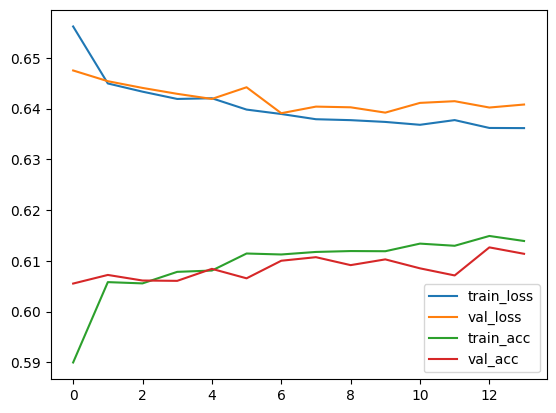

In [12]:
# 학습
train_func(train_data, train_label, lstm_model)

### 모델 추론

In [ ]:
# 평가용 데이터셋
# torch Tensor 변환
test_target = ratings_test_df['label'].values   
padded_test = torch.tensor(test_padded, dtype=torch.long)
test_target = torch.tensor(test_target, dtype=torch.float)

test_dataset = TensorDataset(padded_test, test_target)
test_loader = DataLoader(test_dataset, batch_size=65)

# 평가 함수 정의
def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for val_inputs, val_targets in test_loader:
            val_outputs = model(val_inputs)       
            loss = criterion(val_outputs, val_targets)
            val_loss += loss.item()

            val_pred = (val_outputs > 0.5).float()
            val_correct += (val_pred == val_targets).sum().item()
            val_total += val_targets.size(0)

    val_loss = val_loss / len(test_loader)
    val_acc = val_correct / val_total
    return val_loss, val_acc

# 모델 평가
criterion = nn.BCELoss()
loss, accuracy = evaluate_model(lstm_model, test_loader, criterion)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

Test Loss: 0.6403, Test Accuracy: 0.6087


### 문장 예측

In [14]:
# 문장 예측 함수
def predict_sentiment(model, tokenizer, sentence, max_len=50, device="cpu"):
    
    model.eval()

    tokens = preprocessing(pd.DataFrame({"document":[sentence]}))[0][0]   # 내 전처리 함수 활용
    seq = tokenizer.texts_to_sequences([tokens])
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

    input_tensor = torch.tensor(padded, dtype=torch.long).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        prob = output.item() 

    label = 1 if prob > 0.5 else 0
    return label, prob

In [16]:
while True:
    input_sentence = input("긍정/부정 예측할 문장을 입력하세요! (중단하려면 'X' 입력)")

    if input_sentence != 'X':
        label, prob = predict_sentiment(lstm_model, tokenizer, input_sentence, max_len=50)

        print(f"문장: {input_sentence}")
        print(f"긍/부정 예측: {'긍정' if label==1 else '부정'} (확률={prob:.4f})")

    elif input_sentence == 'X':
        break

100%|██████████| 1/1 [00:00<00:00, 1251.28it/s]

문장: 오늘은 날씨가 좋아요
긍/부정 예측: 긍정 (확률=0.7144)



100%|██████████| 1/1 [00:00<00:00, 855.63it/s]

문장: 비가 와서 우울해요
긍/부정 예측: 부정 (확률=0.4240)



100%|██████████| 1/1 [00:00<00:00, 529.12it/s]

문장: 자연어 공부는 재밌어요
긍/부정 예측: 긍정 (확률=0.8337)



100%|██████████| 1/1 [00:00<00:00, 1047.27it/s]

문장: 그치만 어려워요
긍/부정 예측: 부정 (확률=0.4389)
